In [1]:
import sys, os
sys.path.append('./src')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


import pandas as pd 
import numpy as np
import random 
import scanpy as sc

from model import Encoder, Decoder, OutputLayer
from loss_function import ZINB, maximum_mean_discrepancy
from train import train_epoch_mmd
from utils import plot_train, preproc_filter, vis_latent_emb, load_batches
from dataset import dataset
from scipy import sparse

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading the dataset
We use the Pancreas data from paper (https://www.biorxiv.org/content/10.1101/2020.05.22.111161v2),
which has 8 batches but no time information

In [2]:
# Load pancreas files info
pancreas_files = None
for roots, dirs, files in os.walk('./data/Pancreas'):
    pancreas_files = files

mtx_file_lst = [i for i in pancreas_files if i.endswith('.npz')]
meta_file_lst = [i for i in pancreas_files if i.endswith('.csv') and 'meta' in i]
gene_file = [i for i in pancreas_files if 'gene' in i]
print(mtx_file_lst, meta_file_lst, gene_file)

['GxC2.npz', 'GxC1.npz', 'GxC6.npz', 'GxC7.npz', 'GxC3.npz', 'GxC5.npz', 'GxC0.npz', 'GxC4.npz'] ['meta_c5.csv', 'meta_c1.csv', 'meta_c2.csv', 'meta_c7.csv', 'meta_c4.csv', 'meta_c0.csv', 'meta_c3.csv', 'meta_c6.csv'] ['gene.csv']


In [3]:
path_base = r'./data/Pancreas/'
batch_num_1, batch_num_2 = 0, 5
data_batch_1, data_anno_1, data_batch_2, data_anno_2 = load_batches(batch_num_1, batch_num_2, 
                                                        meta_file_lst, mtx_file_lst, path_base)
anno_1, anno_2 = np.array(data_anno_1['celltype']), np.array(data_anno_2['celltype'])
print(len(list(set(anno_1))), len(list(set(anno_2))))

Loading batch file 1: GxC0.npz	 with meta file 1:meta_c0.csv
Loading batch file 1: GxC5.npz	 with meta file 1:meta_c5.csv
Batch 1 size:(1004, 8634)	Meta 1 size:(1004, 2)
Batch 2 size:(1724, 8634)	Meta 2 size:(1724, 2)
13 14


In [4]:
# All batches use this fixed map of cell types and numbers to plot
cell_types_unique = ['activated_stellate', 'quiescent_stellate', 'epsilon', 'endothelial', 'mast', 'schwann', 'alpha', 't_cell', 'gamma', 'delta', 'macrophage', 'ductal', 'acinar', 'beta']
maps = dict(zip(range(len(cell_types_unique)), cell_types_unique))
print(maps)

{0: 'activated_stellate', 1: 'quiescent_stellate', 2: 'epsilon', 3: 'endothelial', 4: 'mast', 5: 'schwann', 6: 'alpha', 7: 't_cell', 8: 'gamma', 9: 'delta', 10: 'macrophage', 11: 'ductal', 12: 'acinar', 13: 'beta'}


### Training

Loading batch file 1: GxC4.npz	 with meta file 1:meta_c4.csv
Loading batch file 1: GxC6.npz	 with meta file 1:meta_c6.csv
Batch 1 size:(1937, 8634)	Meta 1 size:(1937, 2)
Batch 2 size:(3605, 8634)	Meta 2 size:(3605, 2)

 EPOCH 1/300 	 train loss 0.8276855555402907

 EPOCH 2/300 	 train loss 0.8081884920812478

 EPOCH 3/300 	 train loss 0.8041777820025884

 EPOCH 4/300 	 train loss 0.8011425335381409

 EPOCH 5/300 	 train loss 0.7988811329461031


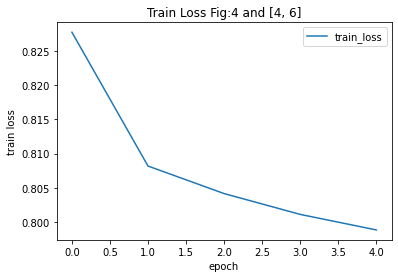


 EPOCH 6/300 	 train loss 0.7965948511536243

 EPOCH 7/300 	 train loss 0.7953808163636483

 EPOCH 8/300 	 train loss 0.7948600639063609

 EPOCH 9/300 	 train loss 0.7933731453284567

 EPOCH 10/300 	 train loss 0.792889476376338


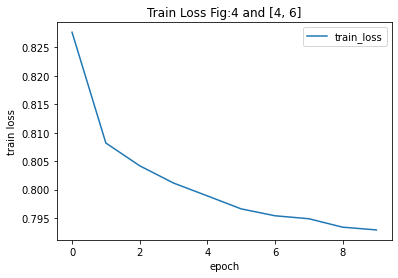


 EPOCH 11/300 	 train loss 0.7928367677766389

 EPOCH 12/300 	 train loss 0.7933814147728647

 EPOCH 13/300 	 train loss 0.791970197355618

 EPOCH 14/300 	 train loss 0.7915672928510281

 EPOCH 15/300 	 train loss 0.7914419120036269


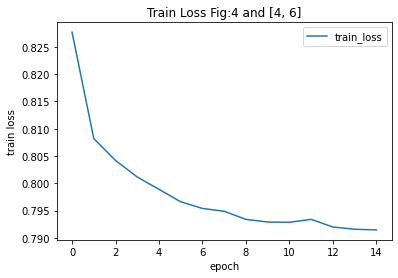


 EPOCH 16/300 	 train loss 0.7900390881019951

 EPOCH 17/300 	 train loss 0.7895809443389624

 EPOCH 18/300 	 train loss 0.7887995812963073

 EPOCH 19/300 	 train loss 0.7893864420436373

 EPOCH 20/300 	 train loss 0.7886364237204864


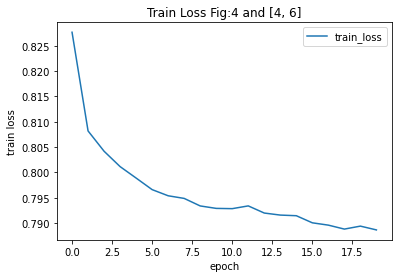


 EPOCH 21/300 	 train loss 0.7881634012595489

 EPOCH 22/300 	 train loss 0.7877549686934078

 EPOCH 23/300 	 train loss 0.7872808236834556

 EPOCH 24/300 	 train loss 0.7867615482643454

 EPOCH 25/300 	 train loss 0.7874565892571571


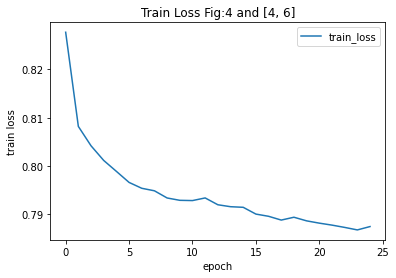


 EPOCH 26/300 	 train loss 0.786257892031613

 EPOCH 27/300 	 train loss 0.7856118729512102

 EPOCH 28/300 	 train loss 0.7859134073410073

 EPOCH 29/300 	 train loss 0.7858834234660104

 EPOCH 30/300 	 train loss 0.7849562649389611


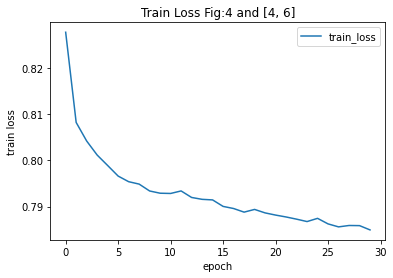


 EPOCH 31/300 	 train loss 0.7846111953412372

 EPOCH 32/300 	 train loss 0.7847699769452853

 EPOCH 33/300 	 train loss 0.7840967547604271

 EPOCH 34/300 	 train loss 0.7842507724240076

 EPOCH 35/300 	 train loss 0.7833945136988477


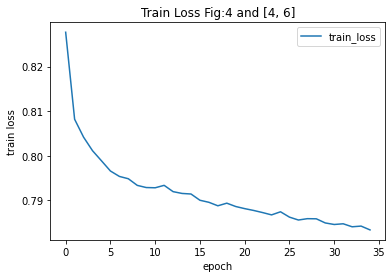


 EPOCH 36/300 	 train loss 0.7833542653932114

 EPOCH 37/300 	 train loss 0.7826245179420042

 EPOCH 38/300 	 train loss 0.7833712533016333

 EPOCH 39/300 	 train loss 0.7818073160450176

 EPOCH 40/300 	 train loss 0.7821399923077427


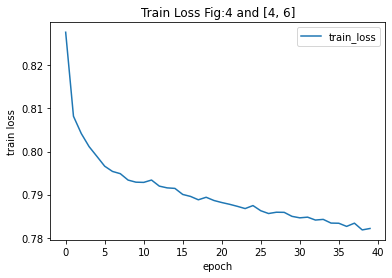


 EPOCH 41/300 	 train loss 0.781618611616884

 EPOCH 42/300 	 train loss 0.7812838084191838

 EPOCH 43/300 	 train loss 0.7812618064584963

 EPOCH 44/300 	 train loss 0.7809951104758385

 EPOCH 45/300 	 train loss 0.7804606648899565


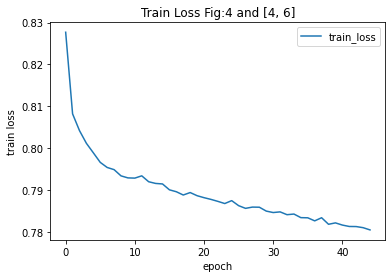


 EPOCH 46/300 	 train loss 0.7809264144149095

 EPOCH 47/300 	 train loss 0.7803502198526031

 EPOCH 48/300 	 train loss 0.7802963906732735

 EPOCH 49/300 	 train loss 0.7808610525214924

 EPOCH 50/300 	 train loss 0.7794293988040261


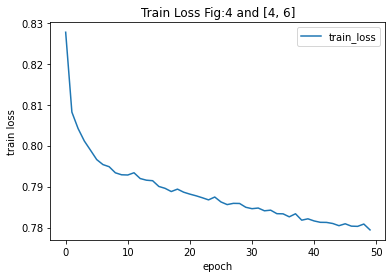


 EPOCH 51/300 	 train loss 0.7797129369606723

 EPOCH 52/300 	 train loss 0.7794833008505724

 EPOCH 53/300 	 train loss 0.7789097688957534

 EPOCH 54/300 	 train loss 0.7787633924430095

 EPOCH 55/300 	 train loss 0.77838863240854


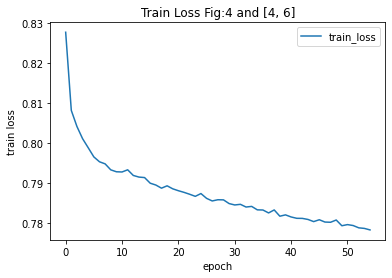


 EPOCH 56/300 	 train loss 0.7778332227274629

 EPOCH 57/300 	 train loss 0.7785807753815501

 EPOCH 58/300 	 train loss 0.7786415151301647

 EPOCH 59/300 	 train loss 0.7780349684180091

 EPOCH 60/300 	 train loss 0.7780750394790642


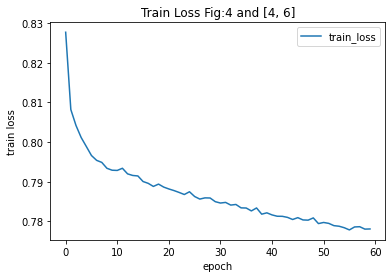


 EPOCH 61/300 	 train loss 0.7778262097501977

 EPOCH 62/300 	 train loss 0.7776132937122634

 EPOCH 63/300 	 train loss 0.7776551116171361

 EPOCH 64/300 	 train loss 0.7776470824376048

 EPOCH 65/300 	 train loss 0.7762123170930452


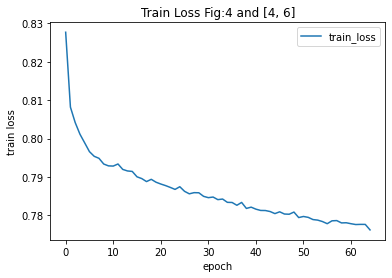


 EPOCH 66/300 	 train loss 0.7768434043021687

 EPOCH 67/300 	 train loss 0.7773089470417769

 EPOCH 68/300 	 train loss 0.7766090790882022

 EPOCH 69/300 	 train loss 0.7764507681669867

 EPOCH 70/300 	 train loss 0.7765877250549285


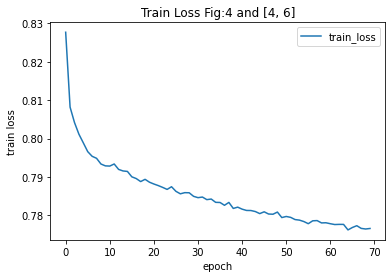


 EPOCH 71/300 	 train loss 0.7762262603334379

 EPOCH 72/300 	 train loss 0.776893588151277

 EPOCH 73/300 	 train loss 0.7763668901229803

 EPOCH 74/300 	 train loss 0.776005994553534

 EPOCH 75/300 	 train loss 0.7760248809483596


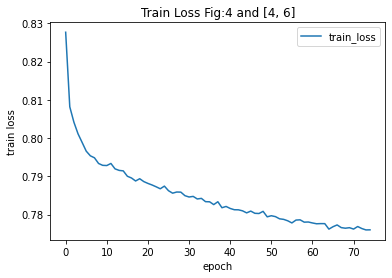


 EPOCH 76/300 	 train loss 0.7762720268537042

 EPOCH 77/300 	 train loss 0.7758766197949017

 EPOCH 78/300 	 train loss 0.775216681106717

 EPOCH 79/300 	 train loss 0.7750504276588767

 EPOCH 80/300 	 train loss 0.7756851227799211


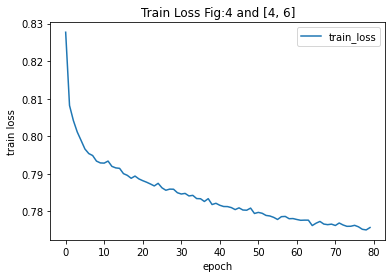


 EPOCH 81/300 	 train loss 0.7753550815533041

 EPOCH 82/300 	 train loss 0.7751825694023609

 EPOCH 83/300 	 train loss 0.7749747619471355

 EPOCH 84/300 	 train loss 0.7742606021721583

 EPOCH 85/300 	 train loss 0.7741964435725096


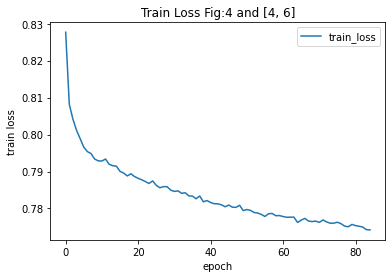


 EPOCH 86/300 	 train loss 0.7746467806964297

 EPOCH 87/300 	 train loss 0.774370066456162

 EPOCH 88/300 	 train loss 0.7742949462638544

 EPOCH 89/300 	 train loss 0.7743120326414882

 EPOCH 90/300 	 train loss 0.7739519130094309


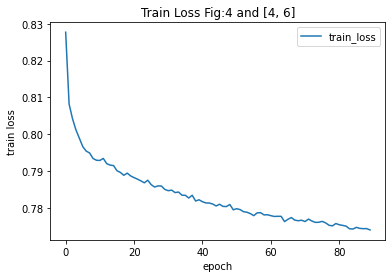


 EPOCH 91/300 	 train loss 0.7744731046394029

 EPOCH 92/300 	 train loss 0.7735542332812197

 EPOCH 93/300 	 train loss 0.7738823070929847

 EPOCH 94/300 	 train loss 0.7738264002132859

 EPOCH 95/300 	 train loss 0.7732691668824061


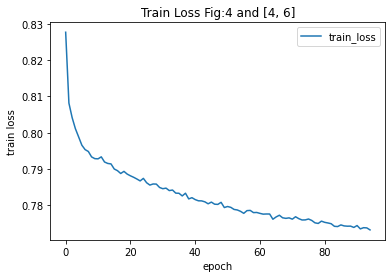


 EPOCH 96/300 	 train loss 0.7732473323193788

 EPOCH 97/300 	 train loss 0.7730755685344454

 EPOCH 98/300 	 train loss 0.7727956264734145

 EPOCH 99/300 	 train loss 0.7722275221415507

 EPOCH 100/300 	 train loss 0.7729723294740124


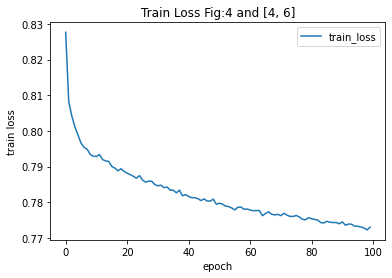


 EPOCH 101/300 	 train loss 0.7721734074015069

 EPOCH 102/300 	 train loss 0.7724559155701975

 EPOCH 103/300 	 train loss 0.7722569939766462

 EPOCH 104/300 	 train loss 0.7719917947260079

 EPOCH 105/300 	 train loss 0.7725418181411987


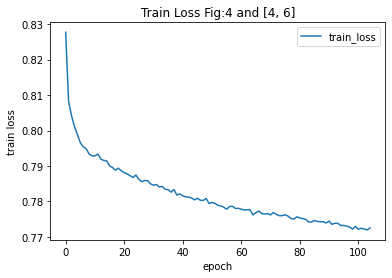


 EPOCH 106/300 	 train loss 0.7717450072485944

 EPOCH 107/300 	 train loss 0.7716151618071296

 EPOCH 108/300 	 train loss 0.7712593118000965

 EPOCH 109/300 	 train loss 0.7713494899042747

 EPOCH 110/300 	 train loss 0.7709884407228579


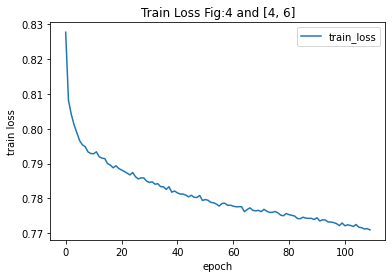


 EPOCH 111/300 	 train loss 0.7715525865924069

 EPOCH 112/300 	 train loss 0.7712930828009799

 EPOCH 113/300 	 train loss 0.7708252516368892

 EPOCH 114/300 	 train loss 0.7706184741696194

 EPOCH 115/300 	 train loss 0.7705478559896758


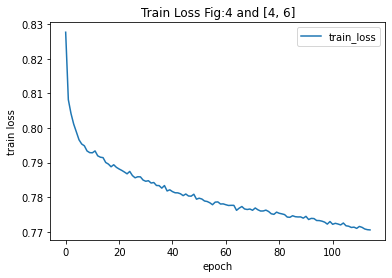


 EPOCH 116/300 	 train loss 0.7702341370196089

 EPOCH 117/300 	 train loss 0.7703693962983391

 EPOCH 118/300 	 train loss 0.7706890293292674

 EPOCH 119/300 	 train loss 0.7706796550603029

 EPOCH 120/300 	 train loss 0.7706836174613863


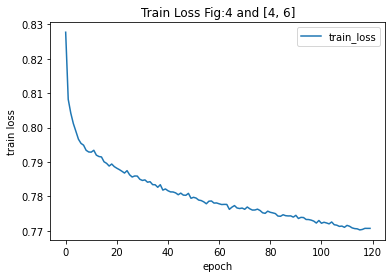


 EPOCH 121/300 	 train loss 0.7706332248575489

 EPOCH 122/300 	 train loss 0.7703926173078688

 EPOCH 123/300 	 train loss 0.7704947968395826

 EPOCH 124/300 	 train loss 0.7702534960666513

 EPOCH 125/300 	 train loss 0.7700941571268644


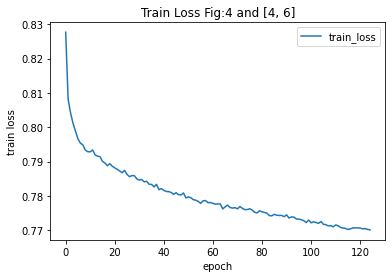


 EPOCH 126/300 	 train loss 0.7704218823576195

 EPOCH 127/300 	 train loss 0.7709918162474388

 EPOCH 128/300 	 train loss 0.7700428526981258

 EPOCH 129/300 	 train loss 0.7697938260308356

 EPOCH 130/300 	 train loss 0.7704996612186461


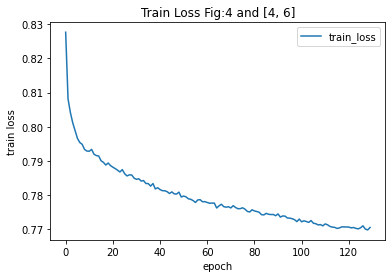


 EPOCH 131/300 	 train loss 0.7703430006414206

 EPOCH 132/300 	 train loss 0.7700033054932774

 EPOCH 133/300 	 train loss 0.7698479525871847

 EPOCH 134/300 	 train loss 0.7703914671874748

 EPOCH 135/300 	 train loss 0.7699685675247342


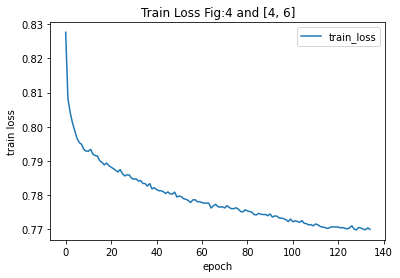


 EPOCH 136/300 	 train loss 0.7700861397636386

 EPOCH 137/300 	 train loss 0.7697050343731598

 EPOCH 138/300 	 train loss 0.7699779122529352

 EPOCH 139/300 	 train loss 0.7704639168947581

 EPOCH 140/300 	 train loss 0.7704161376638023


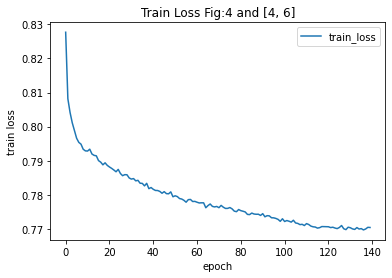


 EPOCH 141/300 	 train loss 0.7696814175173986

 EPOCH 142/300 	 train loss 0.7698495241558053

 EPOCH 143/300 	 train loss 0.7697451783014316

 EPOCH 144/300 	 train loss 0.7696379689623783

 EPOCH 145/300 	 train loss 0.7700356565681264


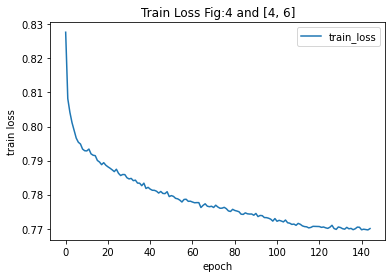


 EPOCH 146/300 	 train loss 0.770892045272646

 EPOCH 147/300 	 train loss 0.7696558785426229

 EPOCH 148/300 	 train loss 0.7696181589263459

 EPOCH 149/300 	 train loss 0.7702078595257446

 EPOCH 150/300 	 train loss 0.7702045903479123


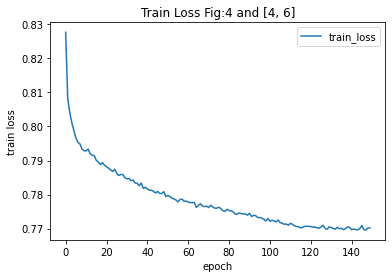


 EPOCH 151/300 	 train loss 0.7703691737579204

 EPOCH 152/300 	 train loss 0.7698737318268374

 EPOCH 153/300 	 train loss 0.7696157247674299

 EPOCH 154/300 	 train loss 0.7701953834766079

 EPOCH 155/300 	 train loss 0.7699196814998377


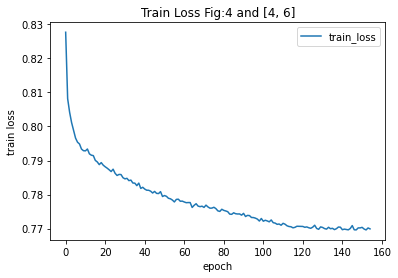


 EPOCH 156/300 	 train loss 0.7691416408083891

 EPOCH 157/300 	 train loss 0.7700475339244554

 EPOCH 158/300 	 train loss 0.770002543341578

 EPOCH 159/300 	 train loss 0.7695195735208632

 EPOCH 160/300 	 train loss 0.7700701010984186


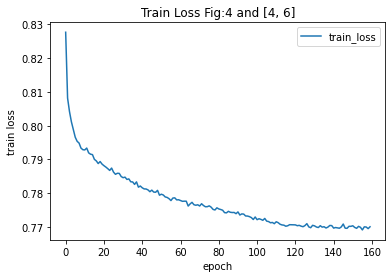


 EPOCH 161/300 	 train loss 0.769748733039978

 EPOCH 162/300 	 train loss 0.7690798316841342

 EPOCH 163/300 	 train loss 0.7694907082561124

 EPOCH 164/300 	 train loss 0.7694421550571519

 EPOCH 165/300 	 train loss 0.7699235296766354


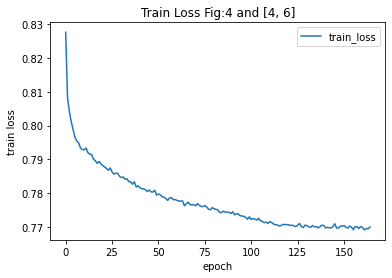


 EPOCH 166/300 	 train loss 0.7695064062178596

 EPOCH 167/300 	 train loss 0.7690058852448314

 EPOCH 168/300 	 train loss 0.7693902223948418

 EPOCH 169/300 	 train loss 0.769104179181447

 EPOCH 170/300 	 train loss 0.7701234320235363


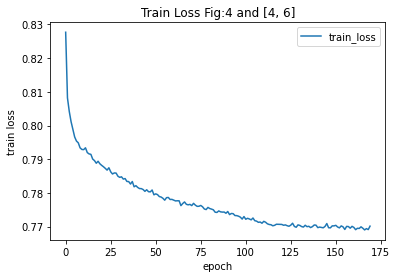


 EPOCH 171/300 	 train loss 0.7696117367643515

 EPOCH 172/300 	 train loss 0.7702403957227117

 EPOCH 173/300 	 train loss 0.7700787092769152

 EPOCH 174/300 	 train loss 0.7691412213295468

 EPOCH 175/300 	 train loss 0.7692485094439694


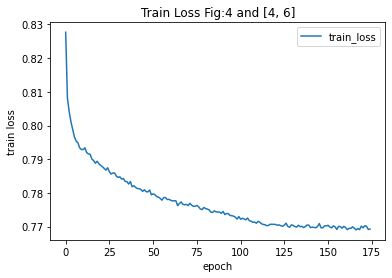


 EPOCH 176/300 	 train loss 0.7688382236872621

 EPOCH 177/300 	 train loss 0.7699664346816063

 EPOCH 178/300 	 train loss 0.7691517260250629

 EPOCH 179/300 	 train loss 0.7694994247507422

 EPOCH 180/300 	 train loss 0.7694002623156783


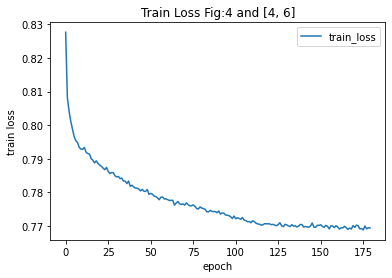


 EPOCH 181/300 	 train loss 0.7694960748281563

 EPOCH 182/300 	 train loss 0.7697822145413786

 EPOCH 183/300 	 train loss 0.7688834269636368

 EPOCH 184/300 	 train loss 0.7692196146384551

 EPOCH 185/300 	 train loss 0.7696784752573497


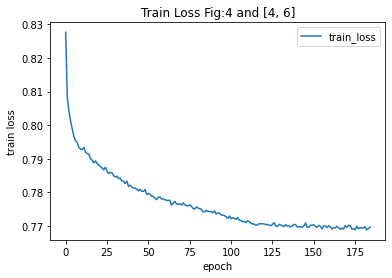


 EPOCH 186/300 	 train loss 0.7692568635718996

 EPOCH 187/300 	 train loss 0.7694464581617081

 EPOCH 188/300 	 train loss 0.7695933821032696

 EPOCH 189/300 	 train loss 0.7697009222988745

 EPOCH 190/300 	 train loss 0.7698709431787588


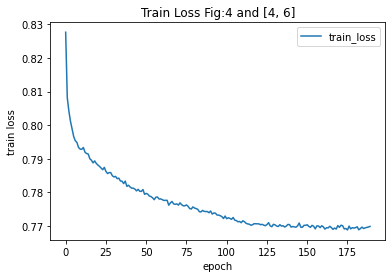


 EPOCH 191/300 	 train loss 0.7690912659290099

 EPOCH 192/300 	 train loss 0.7691517319332156

 EPOCH 193/300 	 train loss 0.7701352187881902

 EPOCH 194/300 	 train loss 0.7693133297567215

 EPOCH 195/300 	 train loss 0.7689242188193224


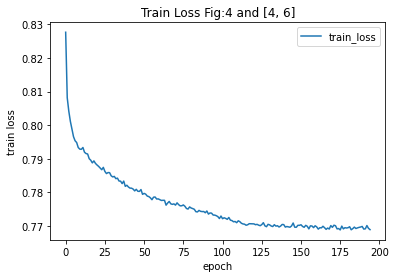


 EPOCH 196/300 	 train loss 0.7695681149035184

 EPOCH 197/300 	 train loss 0.7686237026011753

 EPOCH 198/300 	 train loss 0.7692267556256958

 EPOCH 199/300 	 train loss 0.7689328013958239

 EPOCH 200/300 	 train loss 0.7691450439043493


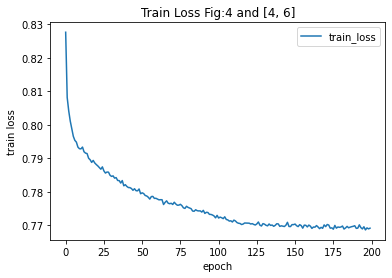


 EPOCH 201/300 	 train loss 0.769707253869194

 EPOCH 202/300 	 train loss 0.7692080267816089

 EPOCH 203/300 	 train loss 0.768905935056073

 EPOCH 204/300 	 train loss 0.7693116223005887

 EPOCH 205/300 	 train loss 0.7695924210437624


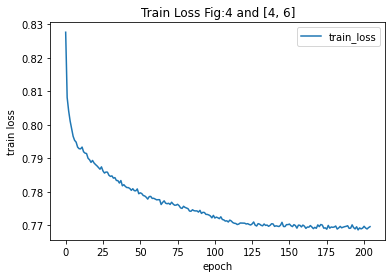


 EPOCH 206/300 	 train loss 0.7691468537684625

 EPOCH 207/300 	 train loss 0.7691377611214436

 EPOCH 208/300 	 train loss 0.7689464098408965

 EPOCH 209/300 	 train loss 0.7690913210717685

 EPOCH 210/300 	 train loss 0.7694584398954014


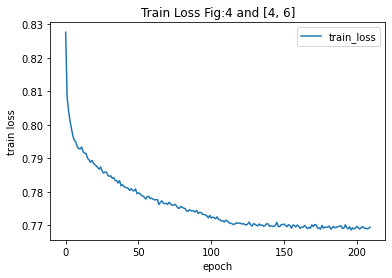


 EPOCH 211/300 	 train loss 0.7688560800941322

 EPOCH 212/300 	 train loss 0.7697147079885283

 EPOCH 213/300 	 train loss 0.769593994581767

 EPOCH 214/300 	 train loss 0.7692356670893647

 EPOCH 215/300 	 train loss 0.7686635097647427


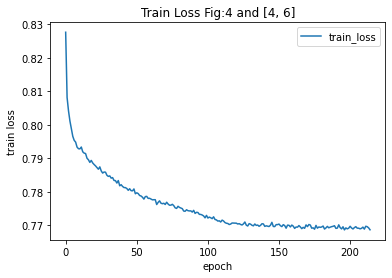


 EPOCH 216/300 	 train loss 0.7687054222000587

 EPOCH 217/300 	 train loss 0.7688630241429492

 EPOCH 218/300 	 train loss 0.7694628473773222

 EPOCH 219/300 	 train loss 0.7694626858878147

 EPOCH 220/300 	 train loss 0.7692786764717003


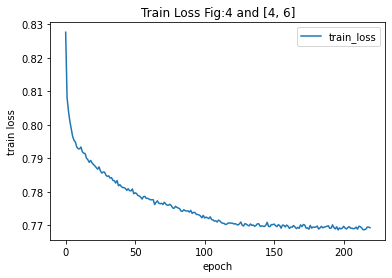


 EPOCH 221/300 	 train loss 0.7691069245030724

 EPOCH 222/300 	 train loss 0.7693379529678274

 EPOCH 223/300 	 train loss 0.7692441925537236

 EPOCH 224/300 	 train loss 0.7692427450563099

 EPOCH 225/300 	 train loss 0.7692818373333995


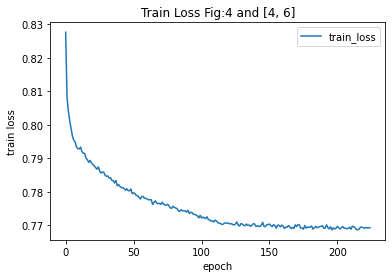


 EPOCH 226/300 	 train loss 0.7693139067863027

 EPOCH 227/300 	 train loss 0.769314934804874

 EPOCH 228/300 	 train loss 0.7687024247972511

 EPOCH 229/300 	 train loss 0.7689865774017791

 EPOCH 230/300 	 train loss 0.7693121205548005


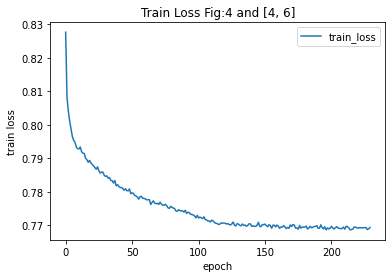


 EPOCH 231/300 	 train loss 0.7690646871193574

 EPOCH 232/300 	 train loss 0.7688990303949407

 EPOCH 233/300 	 train loss 0.7692067919776928

 EPOCH 234/300 	 train loss 0.7696158823181688

 EPOCH 235/300 	 train loss 0.7686327341972827


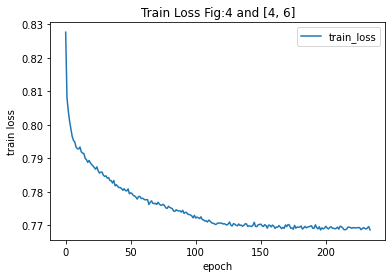


 EPOCH 236/300 	 train loss 0.76926958776345

 EPOCH 237/300 	 train loss 0.7687787226813321

 EPOCH 238/300 	 train loss 0.7684988987833554

 EPOCH 239/300 	 train loss 0.7689351489018336

 EPOCH 240/300 	 train loss 0.7692445273490437


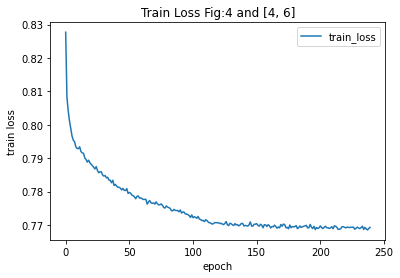


 EPOCH 241/300 	 train loss 0.7690025392610139

 EPOCH 242/300 	 train loss 0.7694356639667091

 EPOCH 243/300 	 train loss 0.7693756706147201

 EPOCH 244/300 	 train loss 0.7695501600274365

 EPOCH 245/300 	 train loss 0.7693285314336411


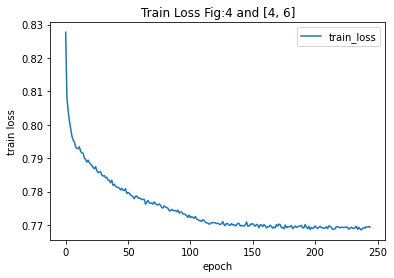


 EPOCH 246/300 	 train loss 0.7689589075532597

 EPOCH 247/300 	 train loss 0.7685994653893797

 EPOCH 248/300 	 train loss 0.7690493830344575

 EPOCH 249/300 	 train loss 0.7683596022669409

 EPOCH 250/300 	 train loss 0.7691308091950897


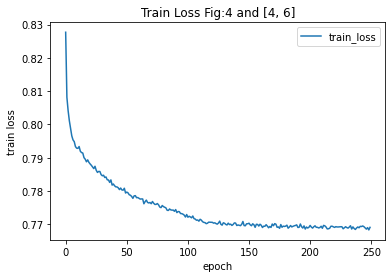


 EPOCH 251/300 	 train loss 0.7690141172709388

 EPOCH 252/300 	 train loss 0.7687985268092119

 EPOCH 253/300 	 train loss 0.7690167483682785

 EPOCH 254/300 	 train loss 0.7688116173062303

 EPOCH 255/300 	 train loss 0.7689359071147644


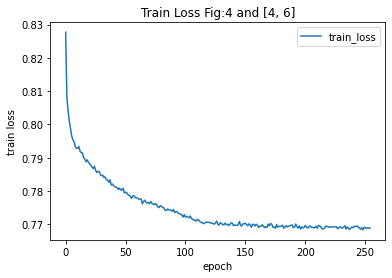


 EPOCH 256/300 	 train loss 0.7690254451690658

 EPOCH 257/300 	 train loss 0.7688550914632456


In [ ]:
# for i in range(0, 7):
#     for j in range(i+1, 8):
#         batch_num_1 = i
#         batch_num_2 = j
batch_num_1 = 4
batch_num_2 = 6
data_batch_1, data_anno_1, data_batch_2, data_anno_2 = load_batches(batch_num_1, batch_num_2, 
                                                        meta_file_lst, mtx_file_lst, path_base)
anno_1, anno_2 = np.array(data_anno_1['celltype']), np.array(data_anno_2['celltype'])

batch_size = 50
seed = 222
random.seed(seed)

# construct training and testing dataset for one batch (day 4)
train_data_1 = dataset(counts = data_batch_1, anno = anno_1)
train_loader_1 = DataLoader(train_data_1, batch_size = batch_size, shuffle=True)

train_data_2 = dataset(counts = data_batch_2, anno = anno_2)
train_loader_2 = DataLoader(train_data_2, batch_size = batch_size, shuffle = True)

if data_batch_1.shape != data_batch_2.shape:
    assert ValueError
net_struc = [data_batch_1.shape[1],512,128, 64, 32]

encoder = Encoder(features=net_struc).to(device)
decoder = Decoder(features=net_struc[1:][::-1]).to(device)

# Three output layer of DCA
output_layer = OutputLayer(net_struc[:2][::-1]).to(device)

# Define Optimizer
lr = 1e-3

#Random seed
torch.manual_seed(seed)
param_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(param_to_optimize, lr=lr)

factor_zinb = 1
factor_mmd = 1.5

num_epochs = 300
all_loss = {'train_loss':[],'test_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch_mmd(encoder,decoder,output_layer,train_loader_1, train_loader_2,optim,factor_zinb,factor_mmd)
    print('\n EPOCH {}/{} \t train loss {}'.format(epoch + 1, num_epochs,train_loss))
    all_loss['train_loss'].append(train_loss)
    all_loss['test_loss'].append(0)
    if epoch and (epoch + 1) % 5 == 0:
        plot_train(all_loss, batches=[batch_num_1, batch_num_2])

test_loader_2 = DataLoader(train_data_2, batch_size = train_data_2.counts.shape[0], shuffle = False)
test_loader_1 = DataLoader(train_data_1, batch_size = train_data_1.counts.shape[0], shuffle = False)

vis_latent_emb(test_loader_1, test_loader_2, encoder, device,
            title = "Embedding of batch {} and {}, epoch {}, mmd {}".format(batch_num_1, batch_num_2, num_epochs, factor_mmd), batches = [batch_num_1, batch_num_2], maps=maps)
plt.savefig('./mmd_1_simpler_net_all_run/'+'emb_{}_&_{}_epoch_{}_lr_fixsed_mmd_{}'.format(batch_num_1, batch_num_2, num_epochs, factor_mmd) + '.png')